In [53]:
# import libraries
import numpy as np
import os 
import cv2
from os import listdir
import tensorflow as tf
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [54]:
## CONFIGURATION
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [55]:
data_path = "./original_dataset/Ghazvin/"
data_list = os.listdir(data_path)

In [56]:
image = cv2.imread(data_path + data_list[0])
resized_image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
resized_image = resized_image.reshape(1, IMG_HEIGHT, IMG_WIDTH, 3) 

In [57]:
resized_image.shape

(1, 128, 128, 3)

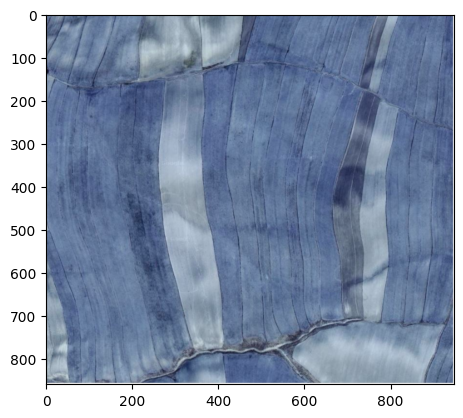

In [58]:
plt.imshow(image)

In [59]:
def plots(img, pred):
    plt.subplot(121)
    plt.imshow(img)
    # plt.show()
    plt.subplot(122)
    plt.imshow(pred)
    plt.show()

In [60]:
# save_path = f"./saved_merged_irfree_dicefocal_dub_bright_images/"
save_path = f"./saved_merged_irfree_bright_ed_64_2_images/"
os.makedirs(save_path, exist_ok=True)

In [61]:
# load model
# model = load_model('models/unetpp-res-att-test-model.h5', compile=False)
model = load_model('models/unetpp-res-att-tverfbeta-64-2-irfree-bright-ed-model.h5', compile=False)
# model = load_model('models/unetpp-res-att-dicefocal-irfree-bright-dub-ed-model.h5', compile=False)

# model.load_weights('./unet-model.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   224         ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   32         ['conv2d[0][0]']                 
 alization)                     8)                                                            

In [62]:
len(model.layers)

108

In [63]:
def create_mask(pred_mask):
    # pred_mask = tf.argmax(pred_mask, axis=-1)
    pred = pred_mask[0]
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0

    # pred_mask = pred_mask[..., tf.newaxis]
    return pred

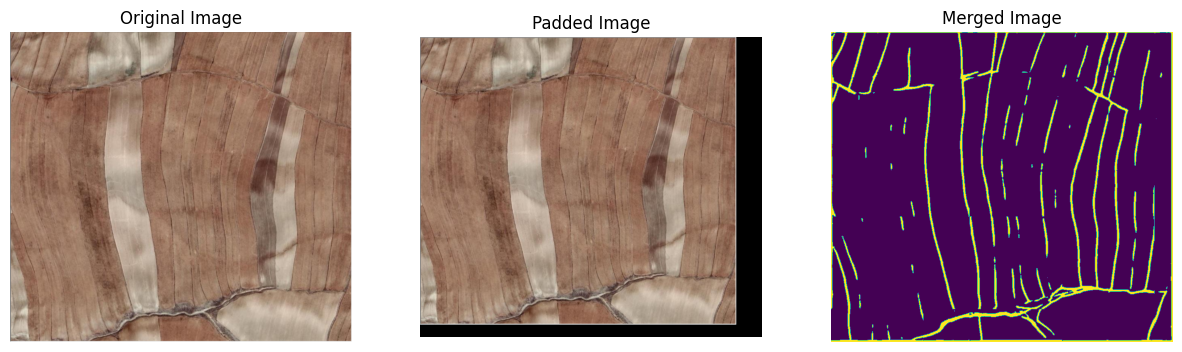

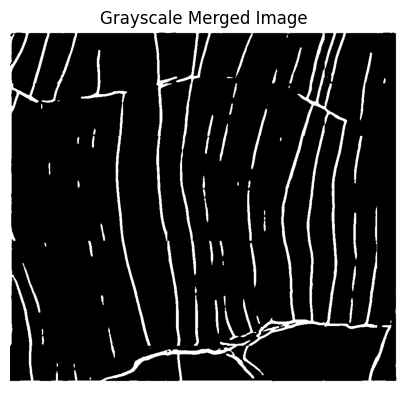

In [64]:
def crop_and_predict_merge_image(image_path, crop_size=128):
    # Read the image
    img = cv2.imread(image_path)
    img_height, img_width, _ = img.shape
    
    # Calculate the number of tiles in each dimension
    num_tiles_x = (img_width + crop_size - 1) // crop_size  # ceil division
    num_tiles_y = (img_height + crop_size - 1) // crop_size  # ceil division

    # Pad the image if necessary
    padded_img = np.zeros((num_tiles_y * crop_size, num_tiles_x * crop_size, 3), dtype=np.uint8)
    padded_img[:img_height, :img_width] = img

    # Initialize the merged image array
    merged_image = np.zeros((num_tiles_y * crop_size, num_tiles_x * crop_size))
    
    # Crop the image, make predictions and merge the results
    for i in range(num_tiles_y):
        for j in range(num_tiles_x):
            y = i * crop_size
            x = j * crop_size
            crop = padded_img[y:y+crop_size, x:x+crop_size]

            reshaped_image = crop.reshape(1, IMG_HEIGHT, IMG_WIDTH, 3)
            normalizedImg = np.zeros_like(reshaped_image)
            normalizedImg = cv2.normalize(reshaped_image,  normalizedImg, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
            # print(resized_image.shape)
            pred_mask = model.predict(normalizedImg, verbose=0)
            # print(pred_mask.max(), pred_mask.min())
            pred_mask = create_mask(pred_mask)
            # Predict on the cropped tile (assuming the model takes and outputs the same shape)
            # prediction = model.predict(crop)
            
            # Place the prediction in the correct position in the merged image
            merged_image[y:y+crop_size, x:x+crop_size] = pred_mask[:,:,0]

    # Crop the merged image to the original size
    merged_image = merged_image[:img_height, :img_width]

    return img, padded_img, merged_image

# Usage example:
image_path = data_path + data_list[0]
original_image, padded_image, merged_image = crop_and_predict_merge_image(image_path)

# Convert to 2D array
# gray_image = cv2.cvtColor(merged_image, cv2.COLOR_BGR2GRAY)
# gray_image_2d = np.array(gray_image)

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(padded_image, cv2.COLOR_BGR2RGB))
axes[1].set_title("Padded Image")
axes[1].axis("off")

axes[2].imshow(merged_image)
axes[2].set_title("Merged Image")
axes[2].axis("off")

plt.show()

# Plot the 2D grayscale image
plt.figure(figsize=(5, 5))
plt.imshow(merged_image, cmap='gray')
plt.title("Grayscale Merged Image")
plt.axis("off")
plt.show()

In [65]:
img_folders = ['Abyek', 'Khorasan', 'Ghazvin', 'Hamedan', 'Ardebil', 'Golestan', 'Markazi', 'ILAM']
for path in img_folders:
    print(path)
    data_path = f"./original_dataset/{path}/"
    img_paths = os.listdir(data_path) 
    for i, dl in enumerate(img_paths):
        # ctr = 0
        # plates = np.ones((60, IMG_HEIGHT, IMG_WIDTH)) * 255
        if dl[-3:] == "jpg":
            original_image, padded_image, merged_image = crop_and_predict_merge_image(data_path + dl)
            cv2.imwrite(f"{save_path}{dl[:-4]}.png", merged_image*255)

Abyek
Khorasan
Ghazvin
Hamedan
Ardebil
Golestan
Markazi
ILAM
